---

## Wikispeedia: What the hell is this?

Since the earliest records, humans have wandered across endless lands and walked thorugh mysterious paths, in an attempt to uncover the unexplored and find better conditions for their tribes. The rise of agriculture and the industrial era has, however, changed things, turning us into bare sedentary animals... until now! 

![](images/heComputer.gif)

[Wikispeedia](https://dlab.epfl.ch/wikispeedia/play/) is an easy and fun game: You are given two Wikipedia articles, and starting from the first article, your goal is to reach the second one exclusively by following links in the articles you encounter, effectively letting you explore your own paths across the vast wikipedia, for free! Your game data is collected by [The EPFL Data Science Lab](https://dlab.epfl.ch/), which helps us and them better understand some aspects of human behaviour 😉.

Using this data, we ask ourselves, are there patterns in the way players navigate the network, that make them more successful? That is, are there any optimal strategy that doesn't require extensive knowledge of the network?

Players are faced with multiple stimulae during the playing session, and players' decisions as well as their posterior success may be influenced by them. For example, users might navigate the network through `semantic similarity` optimization, or they might just click the links found in `images` or `tables`, etc.

Do these particular features have any effect on players' success? Let's see!

---

## A look into the collected data...



In [64]:
import pandas as pd
import os

parent_folder_path = '.data/wikispeedia_paths-and-graph/'

paths_finished_df = (pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                                 sep='\t', skiprows=15, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))

# Read the shortest path matrix
shortest_path_matrix = []
with open('.data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)

        
# next, we need a list of all the article names. The order of the articles 
# is the same as the shortest_path_matrix as per the file descriptions
articles = pd.read_csv('.data/wikispeedia_paths-and-graph/articles.tsv', 
                       sep='\t', 
                       skiprows=11, 
                       header=None)[0]
article_names_cleaned = []

# NOTE TO GINEVRA:
# I need to change the function below to use urlparse

# some articles have encoded names. Decode these
for article in articles:
    # the "%" character indicates an encoded name
    if "%" not in article:
        # store the article name
        article_names_cleaned.append(article)
    else:
        with open(os.path.join('.data/plaintext_articles', f'{article}.txt'), 'r') as f:
            # extract the correct name. It is always on the 3rd line of the article
            correct_name = f.readlines()[2].replace('\n', '')
            # store the article name
            article_names_cleaned.append(correct_name)

article_names_cleaned[:3]


# for each human path, perform the following steps:
#      1. extract the source and target article
#      2. find the *index* in the article names list that corresponds to the source and target article
#      3. the corresponding *index* row in the shortest path matrix corresponds to the source article. 
#         from this list of numbers, use the target article *index* to find the *shortest path length*

def augment_with_shortest_path(df: pd.DataFrame, successful: bool) -> pd.DataFrame:
    """
    this function takes a Series and returns a DataFrame with the following columns:
       1. path
       2. source article
       3. target article
       4. shortest path length
       
    input:
       df: the Pandas DataFrame containing all the human navigation paths
       successful: a boolean indicating whether the paths were successful or not
    """
    # remove all paths with back-tracks
    df = df[~df['path'].str.contains('<')]
    
    def clean_query_article_name(name: str) -> str:
        """this helper function takes an encoded article name and returns the cleaned name"""
        if "%" in name:
            with open(os.path.join('.data/plaintext_articles', f'{name}.txt'), 'r') as f:
                # extract the correct name. It is always on the 3rd line of the article
                return f.readlines()[2].replace('\n', '')    
        else:
            return name
        
    paths, human_path_lengths, source_articles, target_articles, shortest_paths = [], [], [], [], []
    
    # all information required for successful paths is in the path itself
    if successful:
        for human_path in df['path']:
            paths.append(human_path)

            split_path = human_path.split(';')
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = clean_query_article_name(split_path[0])
            target = clean_query_article_name(split_path[-1])
            source_articles.append(source)
            target_articles.append(target)
    
    # unsuccessful paths require extraction of the target article from a separate column
    else:
        for human_path, target in zip(df['path'], df['target']):
            paths.append(human_path)
            
            split_path = human_path.split(';')
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = clean_query_article_name(split_path[0])
            source_articles.append(source)
            target_articles.append(target)
        
    for source, target in zip(source_articles, target_articles):
        source_index = article_names_cleaned.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = article_names_cleaned.index(target)
        except Exception:
            shortest_paths.append("N/A")
            continue
            
        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("Impossible")
        else:
            shortest_paths.append(int(shortest))
        
        
    # create the augmented DataFrame
    out = pd.DataFrame({
                      'path': paths,
                      'source_article': source_articles,
                      'target_article': target_articles,
                      'human_path_length': human_path_lengths,
                      'shortest_path_length': shortest_paths
                      })
    
    return out

successful_df = augment_with_shortest_path(df=paths_finished_df, successful=True)
# to investigate human behaviour, we remove all "Impossible paths" and also shortest_path_length = 0
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x != 'Impossible' and x != 0))]
# next, we will keep only shortest_path_lengths >= 3
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x >= 3))]



unsuccessful_df = augment_with_shortest_path(df=paths_unfinished_df, successful=False)

# some target articles for unsuccessful paths were not provided in the plain_text folder, denoted in
# the DataFrame as "N/A". Remove these
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x != 'N/A' and x != 'Impossible'))]
# some unsuccesful paths only contain 1 article because the user didn't click anything
# these are less meaningful paths to analyze as we are interested in users who tried but failed
# we will keep paths where the human clicked at least 3 articles
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x >= 3))]
unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: x >= 3))]

How are the data distributed among successful and unsuccessful games? The following plots show 

1. The distributions of optimal lengths of the proposed games.
2. The distributions of path lengths obtained by humans.

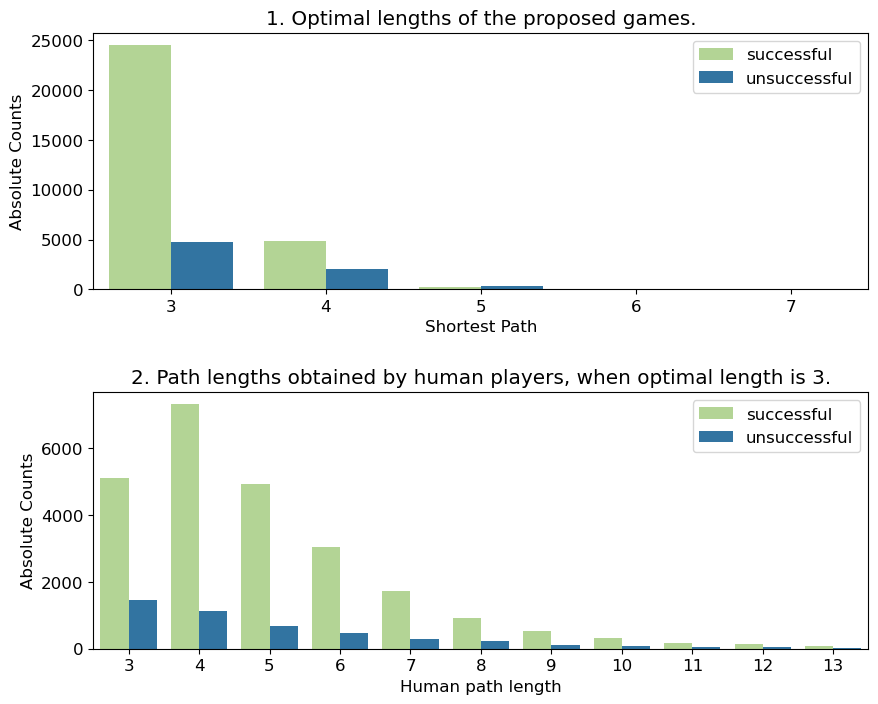

In [71]:
# take a look at the shortest_path distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2,1, 
                       figsize=(10,8), 
                       gridspec_kw={"hspace":0.4})
plt.rcParams["font.size"] = 12


successful_counts = (successful_df['shortest_path_length']
                     .value_counts()
                     .reset_index())
successful_counts["success"] = "successful"

unsuccessful_counts = (unsuccessful_df['shortest_path_length']
                       .value_counts()
                       .reset_index())
unsuccessful_counts["success"] = "unsuccessful"

all_counts = pd.concat([successful_counts, 
                        unsuccessful_counts], 
                       axis=0)

sns.barplot(data=all_counts, 
            x="index", 
            y="shortest_path_length", 
            hue="success",
            ax=ax[0], 
            palette=["#b2df8a", "#1f78b4"])

ax[0].set_ylabel('Absolute Counts'); 
ax[0].set_xlabel('Shortest Path');
ax[0].set_title("1. Optimal lengths of the proposed games.")
#Count of human paths, stratified by shortest possible path")

ax[0].legend(loc=1)
ax[0].set_ylabel('Absolute Counts') 
ax[0].set_xlabel('Shortest Path')



# Next plot: frequency by human length
successful_human_path_lengths_3 = (successful_df
                                   [successful_df['shortest_path_length'] == 3]
                                   ['human_path_length']
                                   .value_counts()
                                   .reset_index())

successful_human_path_lengths_3["success"] = "successful"

unsuccessful_human_path_lengths_3 = (unsuccessful_df
                                     [unsuccessful_df['shortest_path_length'] == 3]
                                     ['human_path_length']
                                     .value_counts()
                                     .reset_index())

unsuccessful_human_path_lengths_3["success"] = "unsuccessful"

all_path_l3 = pd.concat([successful_human_path_lengths_3,
                         unsuccessful_human_path_lengths_3])

sns.barplot(data=all_path_l3, 
            x="index", 
            y="human_path_length", 
            hue="success", 
            ax=ax[1],
            palette=["#b2df8a", "#1f78b4"])

ax[1].set_xlim(-0.5,10.5)

ax[1].set_ylabel('Absolute Counts')
ax[1].set_xlabel('Human path length')
ax[1].set_title("2. Path lengths obtained by human players, when optimal length is 3.")
# Count of human path lengths, with shortest possible path = 3");

ax[1].legend(loc=1);




Given a shortest path length of 3, the majority of human path lengths are 3, 4, 5 for both successful and unsuccessful paths. Let's filter the corresponding DataFrames to only keep these path lengths. The matched analysis will be done with these lengths.

---

## And now the real deal

We wanna test wheather different strategies lead to success in the Wikispeedia game. With this goal in mind, paths can be characterized through local features of the clicked links and articles. The features we extract are:

- Relative position of each hyperlink within the current article.
- Is the hyperlink next to an image?
- Is the hyperlink inside a table?
- Similarity between current and target article.
- Hyperlink curvature along the path.

Once each path has been featurized we perform a matching analysis that lets us reduce the bias in the distributions of successful and unsuccessful populations. For this, we find pairs of `subjects` (paths) in the dataset, that have very similar features, but differ in the one we want to test (the `treatment`). The new distributions will then be much less biased and we will be able to compare the effect of the treatment variable. 

### Confounding variables

Many factors can affect the analysis, among them:

1. the difficulty of each task, and 
2. the strategy adopted to solve it. 

To address the first, we naively quantify `difficulty` of a task as the minimum distance between the source and the target, as determined with the Floyed-Warshall algorithm, while the second is addressed through path length, e.g. the total number of links clicked by each player in the given game.

Controlling by such variables allows a first approximation to controlling these confounding effects.

### Treatment

We will test the effect of clicking mostly links in image boxes.

The question is then: given an equally difficult task assigned, and having a fixed number of possible choices to perform, are players more successful if they adopt `clicking mainly links in images` as a strategy?

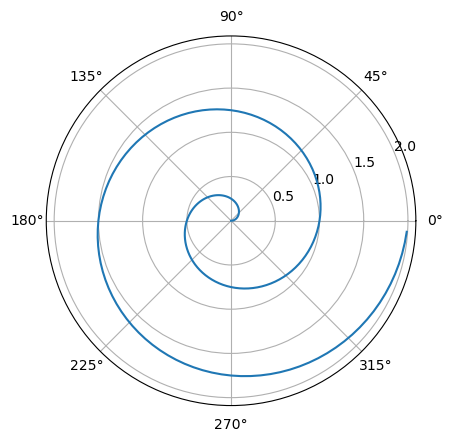

In [1]:
#| label: fig-polar
#| fig-cap: "A line plot on a polar axis"

import numpy as np
import matplotlib.pyplot as plt

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
fig, ax = plt.subplots(
  subplot_kw = {'projection': 'polar'} 
)
ax.plot(theta, r)
ax.set_rticks([0.5, 1, 1.5, 2])
ax.grid(True)
plt.show()